# Brain Cancer Classification With a Quantum hybrid-classical Model

### About the dataset

[link](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)

The data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    -cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    -cjdata.PID: patient ID
    -cjdata.image: image data
    -cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
            -For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
            -It was generated by manually delineating the tumor border. So we can use it to generate
            -binary image of tumor mask.
    -cjdata.tumorMask: a binary image with 1s indicating tumor region

In [1]:
# importing needed libraries
# QML
import pennylane as qml
from pennylane.templates import RandomLayers
# CML
import tensorflow as tf
from tensorflow import keras as K
# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import umap

# calculus
from pennylane import numpy as np


In [2]:
# read from .mat file
f = h5py.File('../brain_tumor_dataset/all/2.mat','r')
img = f.get("cjdata/image")
img = np.array(img) # For converting to a NumPy array

In [3]:
img.shape

(512, 512)

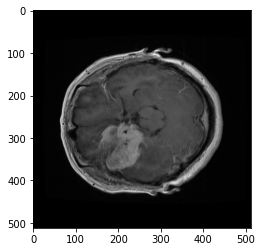

In [31]:
plt.imshow(img, "gray")
plt.show()

In [2]:
# image processing

n_layers=1
wires=4
#rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, wires))

#device_names = ["qiskit.aer", "default.qubit", "qiskit.ibmq"]

dev4 = qml.device("default.qubit", wires=wires)
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # trainable parameter
    theta = np.pi / 2

    qml.RX(phi[i] * np.pi, wires=i)
    qml.RX(phi[i+1] * np.pi, wires=i+1)
    qml.RX(phi[i+2] * np.pi, wires=i+2)
    qml.RX(phi[i+3] * np.pi, wires=i+3)

    qml.CRZ(theta, wires=[i+1, i])
    qml.CRZ(theta, wires=[i+3, i+2])
    qml.CRX(theta, wires=[i+1, i])
    qml.CRX(theta, wires=[i+3, i+2])
    qml.CRZ(theta, wires=[i+2, i])
    qml.CRX(theta, wires=[i+2, i])
    #RandomLayers(rand_params, wires=list(range(4)))
    measurement = qml.expval(qml.PauliZ(wires=i)) # [qml.expval(qml.PauliZ(i)) for i in range(4)]

    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    step2 = 4
    out = np.zeros((H//step, W//step))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # to speed up the calculation a bit I used the mean of each 4x4 pixels :(
            px0 = X[i:i+step2, j:j+step2].mean()
            px1 = X[i:i+step2, j+step2:j+step].mean()
            px2 = X[i+step2:i+step, j:j+step2].mean()
            px3 = X[i+step2:i+step, j+step2:j+step].mean()

            phi = np.array([px0, px1, px2, px3])
            #phi = X[i:i+2, j:j+2].flatten()
            # apply
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out


In [5]:
# Images processing with a Quantum Convolutional Layer
folder = "../brain_tumor_dataset/all/" # .mat files folder

start = timer()
w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
for file in directs:
    #substart = timer()
    #if file+".npz" in all64:
    #    continue
    f = h5py.File(folder+file, 'r')
    image = np.array(f.get("cjdata/image"))
    if image.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]
    NorImages = image/255
    #processed = np.zeros((w//step, w//step))
    processed = QCONV1(NorImages, str(k)+" "+file, len(directs), step)
    mask = np.array(f.get("cjdata/tumorMask"))/255
    processedMask = QCONV1(mask, str(k)+" "+file, len(directs), step)
    #processed[i, j] = Quanv(NorImages[i, j], j+1, NorImages.shape[1])
    np.savez_compressed("../brain_tumor_dataset/processed/all/"+file, image=processed, mask=processedMask, label=label)
    #subend = timer()
    #print("\n"+str(timedelta(seconds=round(subend-substart))))
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

KeyboardInterrupt: 

In [6]:
# get processed data
folder = "../brain_tumor_dataset/processed/all/"
directs = sorted(listdir(folder))

images = []
masks = []
labels = []
i = 0
for file in directs:
    data = np.load(folder+file)
    images.append(data["image"])
    masks.append(data["mask"])
    labels.append(data["label"])
    i+=1

npimages = np.asarray(images)
nplabels = np.asarray(labels)
npmasks = np.asarray(masks)

In [7]:
npimages.shape, nplabels.shape, npmasks.shape

((1584, 64, 64), (1584,), (1584, 64, 64))

In [8]:
# Make a train/test split using 30% test size
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.30,
                                                    random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1108, 64, 64), (476, 64, 64), (1108,), (476,))

In [42]:
import tensorflow as tf
from tensorflow import keras as K

def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(4, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [47]:
q_model = Model()

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=32,
    verbose=2,
)


Epoch 1/32
70/70 - 1s - loss: 0.5046 - accuracy: 0.8276 - val_loss: 0.2731 - val_accuracy: 0.8992
Epoch 2/32
70/70 - 0s - loss: 0.1244 - accuracy: 0.9657 - val_loss: 0.1598 - val_accuracy: 0.9475
Epoch 3/32
70/70 - 0s - loss: 0.0724 - accuracy: 0.9892 - val_loss: 0.1791 - val_accuracy: 0.9307
Epoch 4/32
70/70 - 0s - loss: 0.0502 - accuracy: 0.9946 - val_loss: 0.1231 - val_accuracy: 0.9601
Epoch 5/32
70/70 - 0s - loss: 0.0319 - accuracy: 0.9991 - val_loss: 0.1391 - val_accuracy: 0.9517
Epoch 6/32
70/70 - 0s - loss: 0.0263 - accuracy: 0.9991 - val_loss: 0.1188 - val_accuracy: 0.9559
Epoch 7/32
70/70 - 0s - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9580
Epoch 8/32
70/70 - 0s - loss: 0.0155 - accuracy: 0.9991 - val_loss: 0.1116 - val_accuracy: 0.9643
Epoch 9/32
70/70 - 0s - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1206 - val_accuracy: 0.9580
Epoch 10/32
70/70 - 0s - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.1072 - val_accuracy: 0.9664
Epoch 11/32
70/70 -

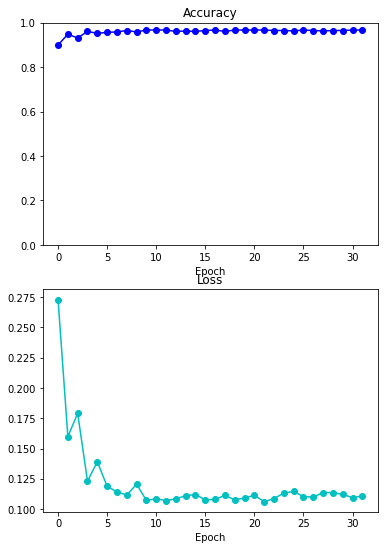

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
ax1.plot(q_history.history["val_accuracy"], "-ob")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(q_history.history["val_loss"], "-oc")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
plt.show()

In [55]:
file = "../brain_tumor_dataset/2435.mat.npz"

data = np.load(file)

npimage = np.asarray([data["image"]])
nplabel = np.asarray([data["label"]])

print(npimage.shape, nplabel.shape, npmask.shape)

yhat = q_model.predict(npimage)

print(yhat.argmax(axis=1) == nplabel)

(1, 64, 64) (1,) (1, 64, 64)
[ True]
